# Expectation-maximization algorithm

## Introduction

In this exercise you will segment three tissue classes in an MR image based on a generative model which you will fit to the image data. You will perform the Expectation-Maximization algorithm to fit the model parameters.
The MR data for this exercise consists of a 2-dimensional slice of a brain scan in the axial
orientation. The file _segmentData.mat_ contains the original slice as well as a mask that excludes
non-brain tissues such as eyeballs, fat, skin, etc. The file _correctedData.mat_ contains the same
image, but after it has been corrected for the MR bias field artifact using the method described in
section 3.5. It is this image you will be modeling.



### Input data and code hints
Import Python libraries:

In [11]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

import matplotlib.mlab as mlab
%matplotlib inline

## Task 1: Image data
Display the image provided in "correctedData.mat" and plot its histogram. Use 100 bins for your histogram

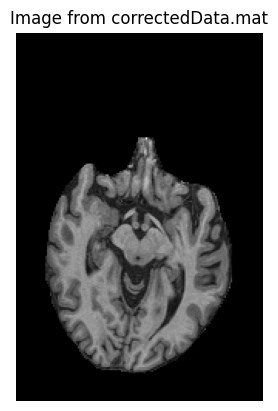

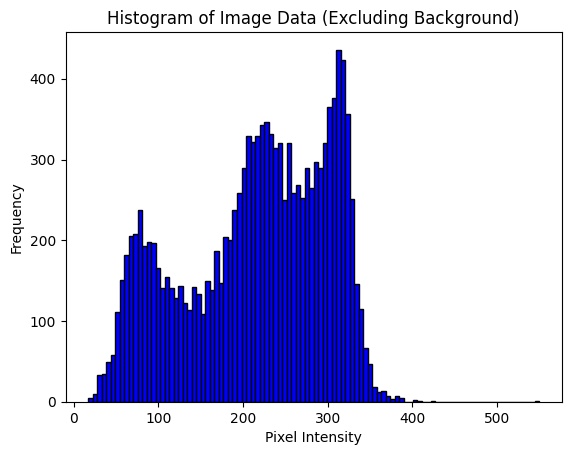

In [12]:
mat = loadmat("correctedData.mat")
data= mat["correctedData"]

plt.imshow(data, cmap='gray')  
plt.title("Image from correctedData.mat")
plt.axis("off")  
plt.show()

data_no_background = data[data > 0]  # Mask out zero values

plt.hist(data_no_background.flatten(), bins=100, color='blue', edgecolor='black')
plt.title("Histogram of Image Data (Excluding Background)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()




The code loads MRI image data from correctedData.mat, displaying the anatomical structure of the brain using a grayscale colormap. The data is visualized using plt.imshow with the colormap set to 'gray', which highlights pixel intensities that correspond to various tissue densities. To analyze the pixel intensity distribution, we had to create a histogram, focusing only on the brain structure by excluding background pixels (intensity values of zero). This exclusion is achieved by creating a mask, data_no_background, which filters out zero-valued pixels. The histogram is generated with 100 bins to capture the range of non-zero pixel intensities, offering insight into the image's intensity variation. The result shows peaks in pixel intensity frequencies, indicating dominant intensity ranges that correlate with different tissue types in the brain which represents gray and white matter.

## Task 2: Initialize Gaussian-Mixture Model
Compute the minimum and maximum intensity in the image (non-zero pixels), and divide the
intensity range up into three equally wide intervals. Initialize the parameters of a 3-component
Gaussian mixture model by setting the means of the Gaussians to the centers of the intensity
intervals, the variances to the square of the width of the intervals, and the prior weights to $\frac{1}{3}$ each.

The minimum intensity 17.078205010324904
The maximum intensity 549.6669350144115
mu1: 105.84299334433933, mu2: 283.37257001236816, mu3: 460.90214668039704
sigma1^2: 31516.750591929533, sigma_2^2: 31516.750591929533, sigma_3^2: 31516.750591929533
pi1: 0.3333333333333333, pi2: 0.3333333333333333, pi3: 0.3333333333333333


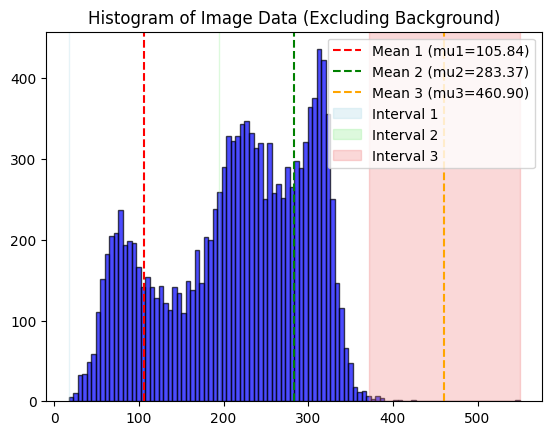

In [13]:
# Step 3: Compute the minimum and maximum intensity
min_intensity = np.min(data_no_background)
print("The minimum intensity", min_intensity)
max_intensity = np.max(data_no_background)
print("The maximum intensity", max_intensity)

interval_width = (max_intensity - min_intensity) / 3
mu1 = min_intensity + interval_width / 2
mu2 = min_intensity + 3 * interval_width / 2
mu3 = max_intensity - interval_width / 2
sigma1_2 = sigma2_2 = sigma3_2 = interval_width**2 

# Step 4: Set prior weights to 1/3 each
pi1 = pi2 = pi3 = 1 / 3


# Print initialized parameters
print(f"mu1: {mu1}, mu2: {mu2}, mu3: {mu3}")
print(f"sigma1^2: {sigma1_2}, sigma_2^2: {sigma2_2}, sigma_3^2: {sigma3_2}")
print(f"pi1: {pi1}, pi2: {pi2}, pi3: {pi3}")

# Plot histogram
plt.hist(data_no_background.flatten(), bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Image Data (Excluding Background)")

# Plot vertical lines for the means (mu1, mu2, mu3)
plt.axvline(mu1, color='red', linestyle='dashed', label=f'Mean 1 (mu1={mu1:.2f})')
plt.axvline(mu2, color='green', linestyle='dashed', label=f'Mean 2 (mu2={mu2:.2f})')
plt.axvline(mu3, color='orange', linestyle='dashed', label=f'Mean 3 (mu3={mu3:.2f})')

# Mark the intervals with shading
plt.axvspan(min_intensity, mu1 - interval_width / 2, color='lightblue', alpha=0.3, label="Interval 1")
plt.axvspan(mu1 + interval_width / 2, mu2 - interval_width / 2, color='lightgreen', alpha=0.3, label="Interval 2")
plt.axvspan(mu2 + interval_width / 2, max_intensity, color='lightcoral', alpha=0.3, label="Interval 3")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

The code initializes a Gaussian Mixture Model (GMM) with three components to model the intensity distribution of the MRI image data. First, it computes the minimum and maximum intensity values from non-background pixels, which are 17.08 and 549.66, respectively. The range between these intensities is divided into three equal-width intervals, each representing a region that is meant to correspond to diferent tissue types. The means (mu1, mu2, mu3) are set at the centers of these intervals (105.84, 283.37, and 460.90), and the variances (sigma1^2, sigma2^2, sigma3^2) are set to the square of each interval's width, yielding variances of approximately 31516.75 for each component. The prior weights for each Gaussian (pi1, pi2, pi3) are set to 1/3 as asked in the task, indicating an equal likelihood for each component initially.

The histogram displays the intensity distribution with vertical dashed lines marking the means of each Gaussian, and shaded regions highlighting each interval. The first peak aligns with mu1 and represents lower-intensity tissues, the middle peak around mu2 corresponds to medium-intensity tissues, and the third peak near mu3 corresponds to higher-intensity tissues. This GMM initialization provides a starting point for more precise parameter estimation, which is crucial for segmenting the image into meaningful regions based on tissue types as we will do later.

## Task 3: Display inital Gaussian distributions
Overlay the resulting Gaussian mixture model on the histogram by plotting each
Gaussian weighted by its $\pi_k$, as well as the total weighted sum of all three Gaussian distributions
(as in fig. 3.1(b) in the course notes).


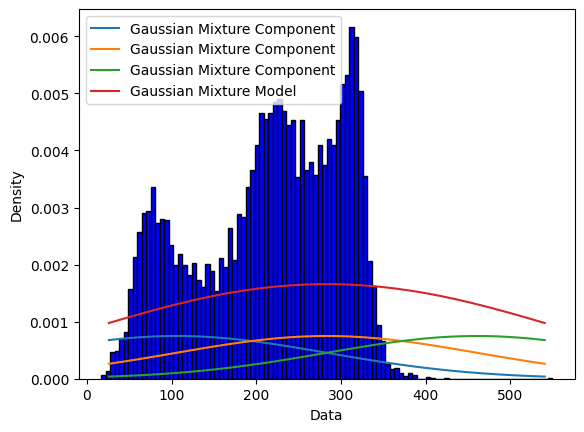

In [4]:

hist, bin_edges = np.histogram(data_no_background, bins=100)
plt.hist(data_no_background.flatten(), bins=100, color='blue', edgecolor='black',density=True)
x= (bin_edges[:-1] + bin_edges[1:])/2

means=[mu1, mu2, mu3]
variances=[sigma1_2, sigma2_2, sigma3_2]
weights=[pi1, pi2, pi3]

def compute_gaussian(x,mean,var):
    return scipy.stats.norm.pdf(x,mean,np.sqrt(var))


for mean,var,weight in zip(means,variances,weights):
   plt.plot(x,weight*compute_gaussian(x,mean,var),label='Gaussian Mixture Component')

total_pdf=np.zeros_like(x)

for mean,var,weight in zip(means,variances,weights):
    total_pdf+=weight*compute_gaussian(x,mean,var)


plt.plot(x,total_pdf,label='Gaussian Mixture Model')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()

The histogram of the data was plotted to represent the observed data distribution, with each bin displaying its density. The compute_gaussian function calculates the probability density function (PDF) of a Gaussian distribution given a mean and variance, which allowed us to plot each Gaussian distribution separately. These Gaussian components were plotted with their respective weights to reflect their contributions to the mixture model.

The code also computes the total PDF by summing the weighted PDFs of all three Gaussians across the data range, reepresenting the entire GMM. This total PDF was then plotted as the Gaussian Mixture Model on top of the histogram to show how well it approximates the observed data distribution.
The  plot shows each Gaussian component's individual contribution and the combined GMM. The GMM shows a smooth, continuous distribution that represents the combined probability density function obtained by summing the weighted contributions of each Gaussian component.

## Task 4: Compute weights
Compute the values of ${w}_{n,k}$ defined by:

$$ \mathcal{w}_{n,k} = \frac{\mathcal{N}(d_n \vert \tilde{\mu}_k, \tilde{\sigma}^2_k) \tilde{\pi}_k}{\sum^K_{k'=1} \mathcal{N}(d_n \vert \tilde{\mu}_k', \tilde{\sigma}^2_{k'}) \tilde{\pi}_k'}. $$

Visualize the values of each ${w}_{n,k}$ in a figure. You should have three plots which each display only the pixels that belong to the respective class, according to the weights. The segmentation of a pixel is determined by assigning the class of the highest probability. 

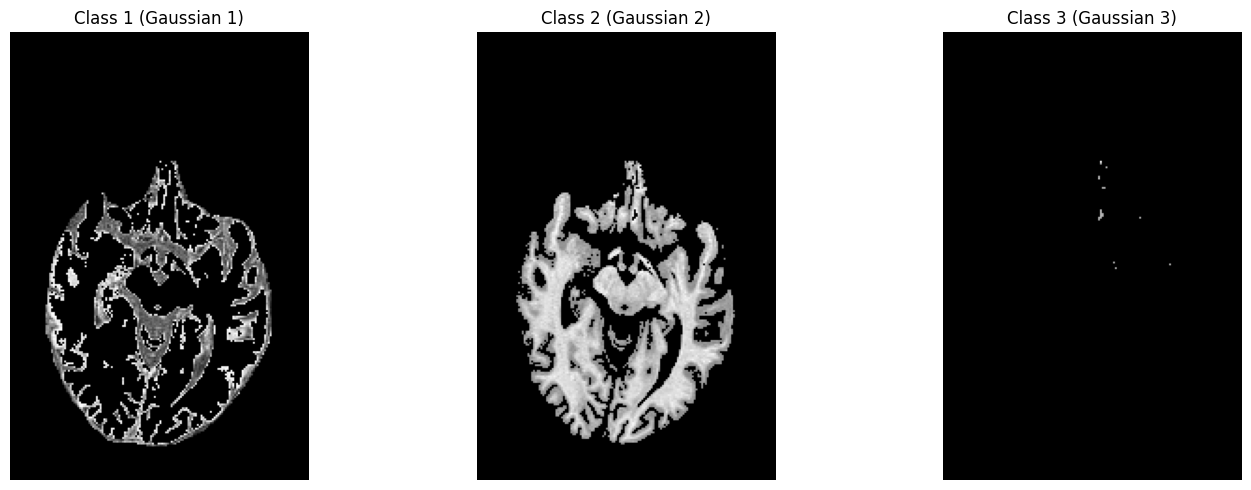

In [5]:

def computing_weights(data, means, variances, weights):
    # Initialize responsibilities array with shape (number of data points, 3 components)
    responsibilities = np.zeros((len(data), 3))
    
    # Iterate over each Gaussian component
    for k in range(3):
        pdf_k = compute_gaussian(data, means[k], variances[k])  # shape should match data
        responsibilities[:, k] = weights[k] * pdf_k  # Broadcasting weights[k] over pdf_k

    # Normalize responsibilities to get w_n,k (posterior probabilities)
    denominator = np.sum(responsibilities, axis=1)[:, np.newaxis]  # shape (len(data), 1)
    w_nk = responsibilities / denominator  # Divide each row by its corresponding sum

    return w_nk


w_nk = computing_weights(data_no_background,means,variances,weights)


max_class = np.argmax(w_nk, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for k in range(3):
   
    mask = (max_class == k)
    
    class_image = np.zeros_like(data)
    class_image[data > 0] = mask * data_no_background
    
    
    axes[k].imshow(class_image, cmap='gray')
    axes[k].set_title(f"Class {k+1} (Gaussian {k+1})")
    axes[k].axis('off')

plt.tight_layout()
plt.show()

Using the function computing_weights, the code computes these weights by first evaluating the probability density function (PDF) of each Gaussian component, given its mean and variance, and then weighting it according to the component’s prior probability (weight) in the mixture. The formula given, 
normalizes these weighted PDFs across all components, producing a probability distribution across the classes for each pixel. Next, np.argmax is used to assign each pixel to the class with the highest probability, resulting in a segmentation map that groups pixels by Gaussian component. The three images generated display masks, where each one corresponds to a specific Gaussian component, highlighting only the pixels most likely to belong to that class. In these images, "Class 1," "Class 2," and "Class 3" represent the areas of the image assigned to the first, second, and third Gaussian components, respectively. These masks reveal the regions of the image that each Gaussian component captures, with different brightness and intensity levels indicating the variations in pixel values across the image, which correspond to different structural features identified by the GMM.

## Task 5: Estimate Maximum Likelihood parameters
Estimate the maximum likelihood parameters by iterating between updating the model parameter
estimate according to 

$$ \tilde{\mu_k} \leftarrow \frac{\sum^N_{n=1} w_{n,k} d_n}{\sum^N_{n=1} w_{n,k}}  $$

$$ \tilde{\sigma}^2_k \leftarrow \frac{\sum^N_{n=1} w_{n,k} (d_n - \tilde{\mu_k})^2}{\sum^N_{n=1} w_{n,k}}  $$

$$ \tilde{\pi_k} \leftarrow \frac{\sum^N_{n=1} w_{n,k}}{N}  $$

and by recomputing ${w}_{n,k}$ according to eq. 3.33 (see Task 4).

Make sure to perform enough iterations (e.g., 100) for the algorithm to converge. As the iterations progress, plot
the evolution of the log likelihood function, and update each time the display of ${w}_{n,k}$ as well as
the Gaussian mixture model plot overlaid on the histogram. Include the evolution of the log
likelihood function and the plot of the final ${w}_{n,k}$ and the final mixture model in your report.


Iteration 0, Log-Likelihood: -14580.782295203151


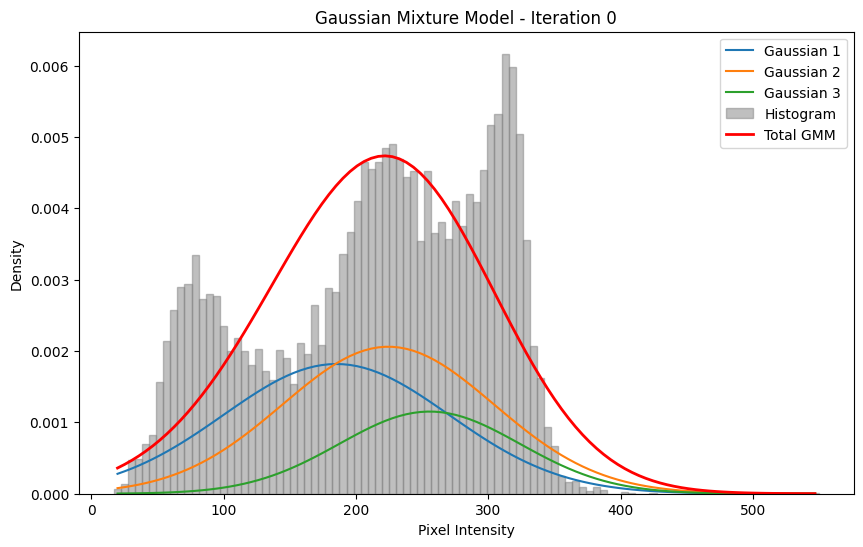

Iteration 10, Log-Likelihood: -14534.341872543875


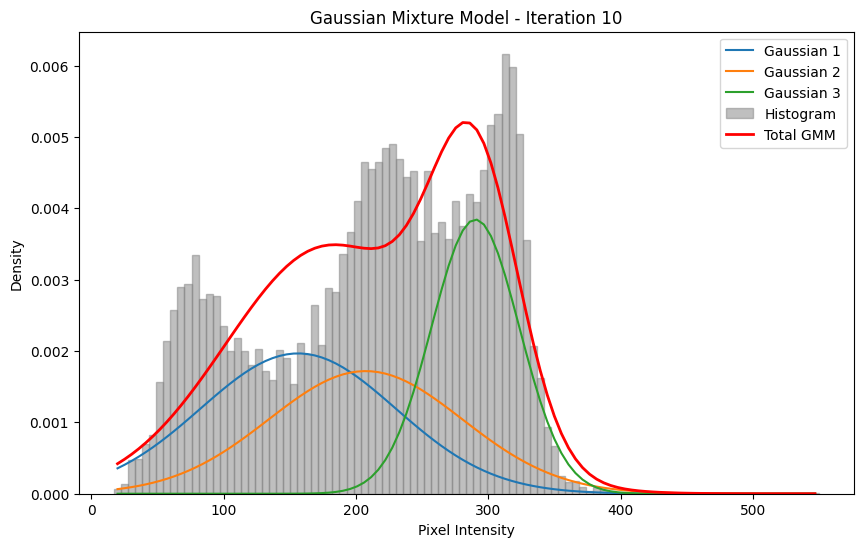

Iteration 20, Log-Likelihood: -14516.551209560834


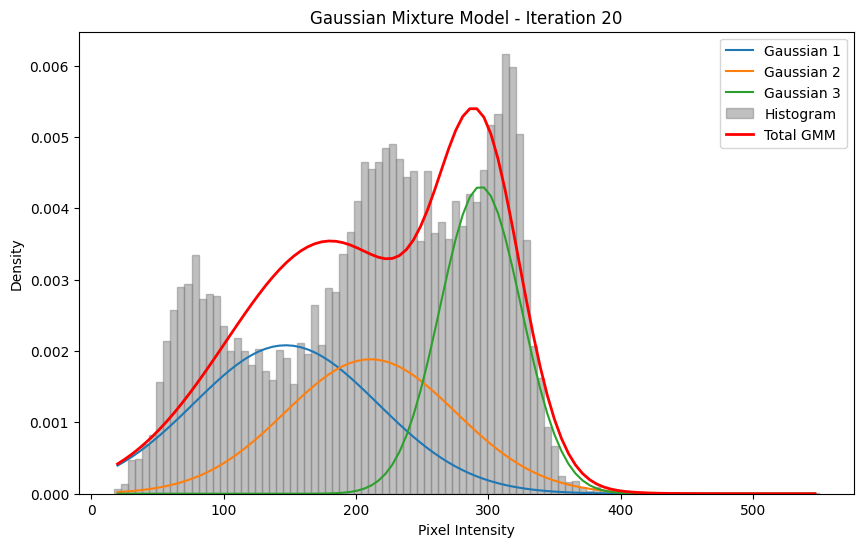

Iteration 30, Log-Likelihood: -14532.444920726994


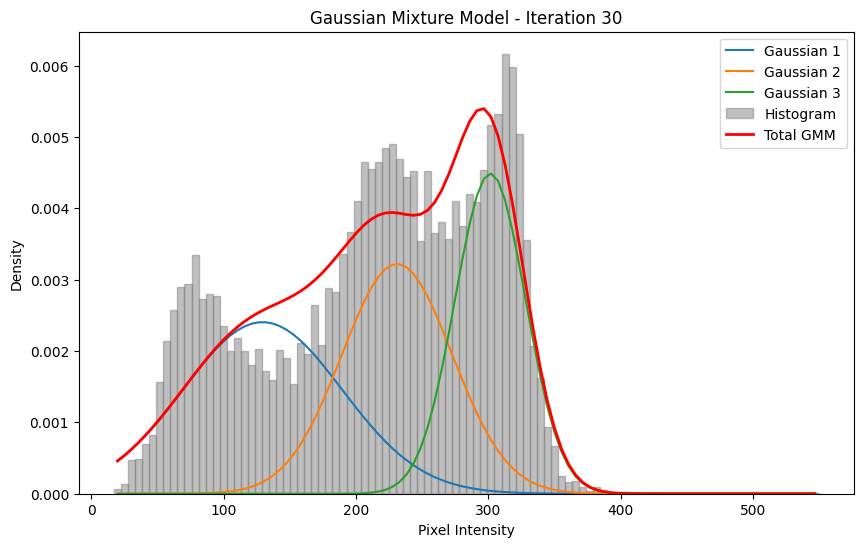

Iteration 40, Log-Likelihood: -14415.929691820758


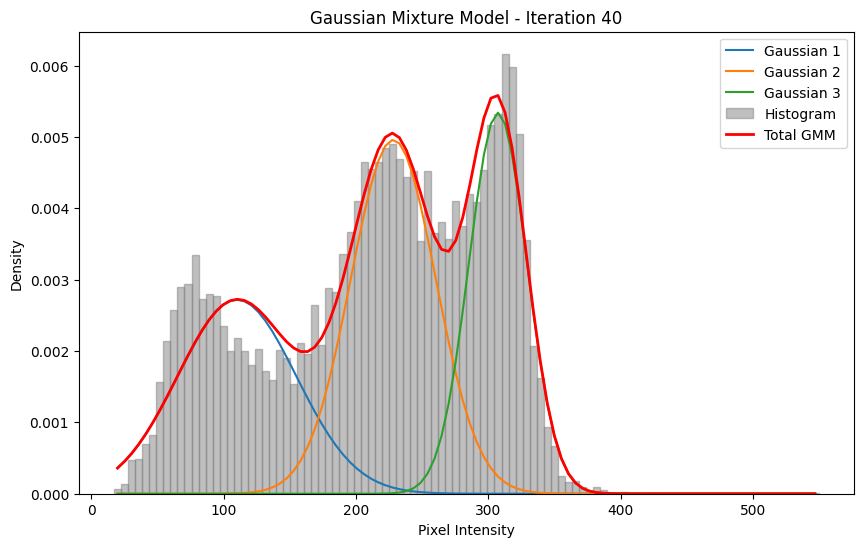

Iteration 50, Log-Likelihood: -14010.23263138193


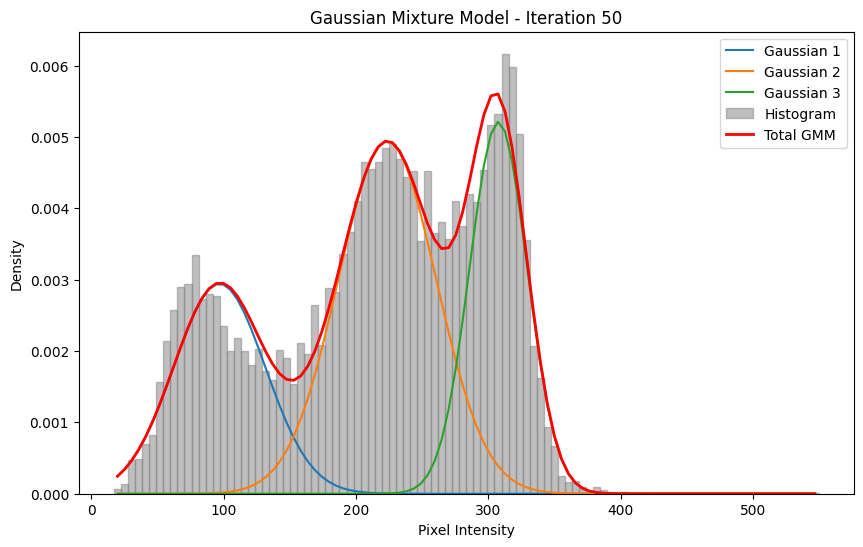

Iteration 60, Log-Likelihood: -13453.36002075683


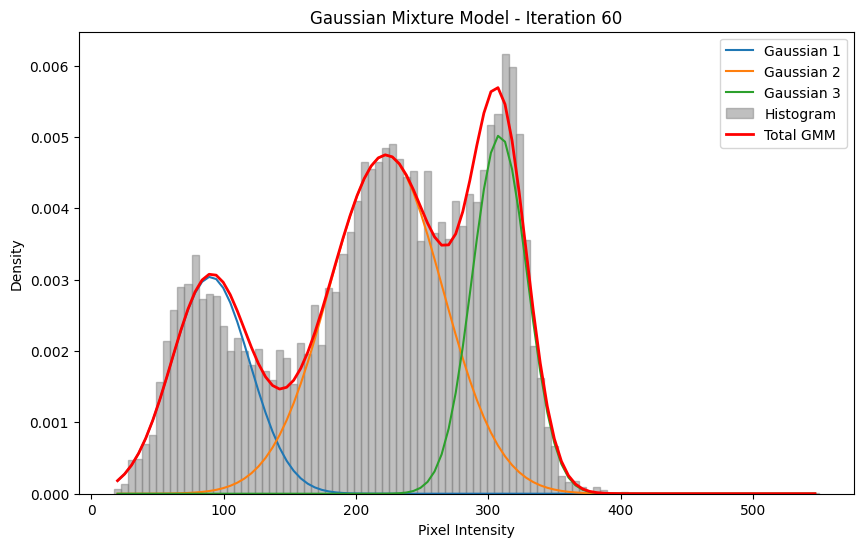

Iteration 70, Log-Likelihood: -12733.01756965972


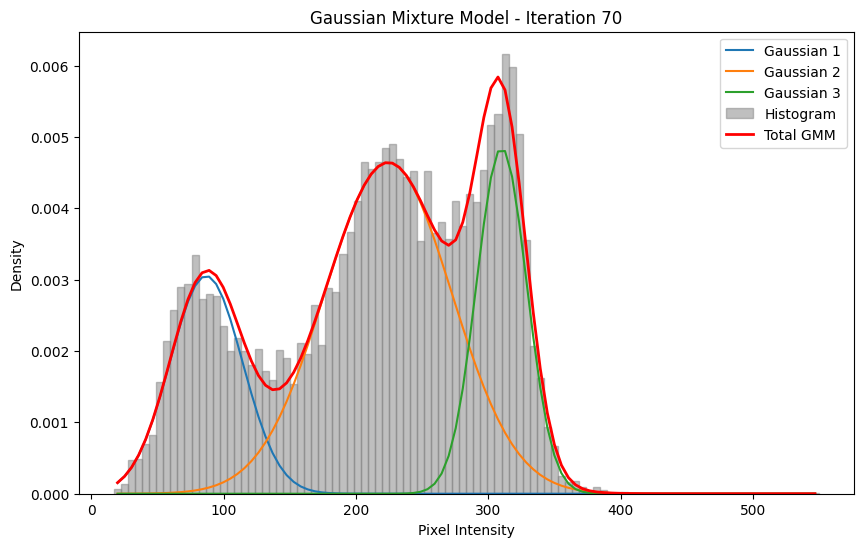

Iteration 80, Log-Likelihood: -12084.481577114322


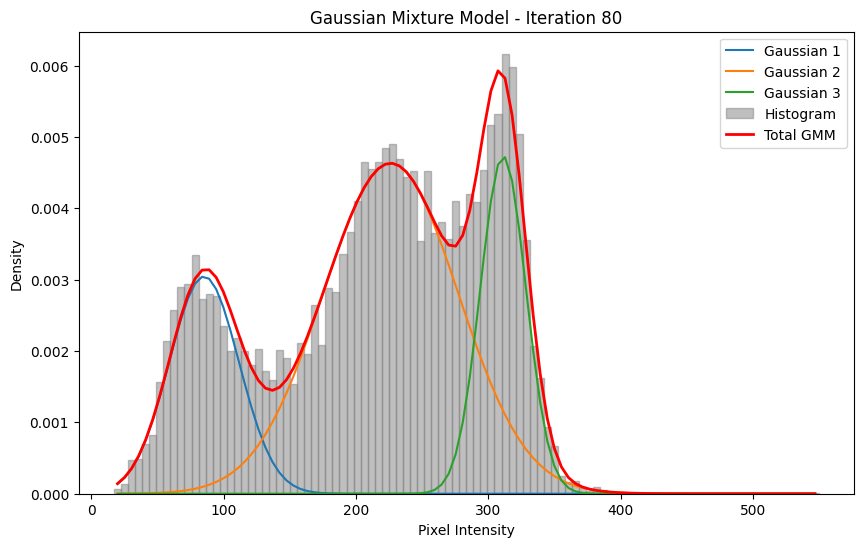

Iteration 90, Log-Likelihood: -11730.264465014445


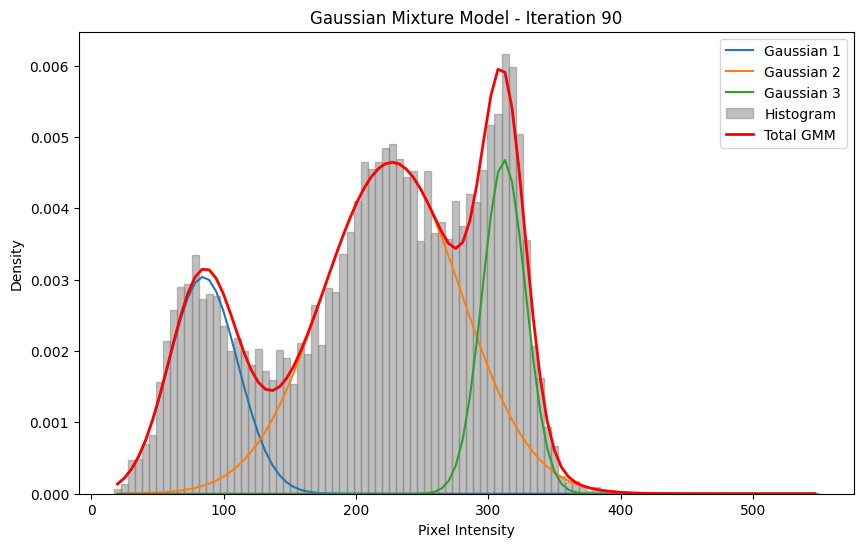

Iteration 100, Log-Likelihood: -11576.934243427593


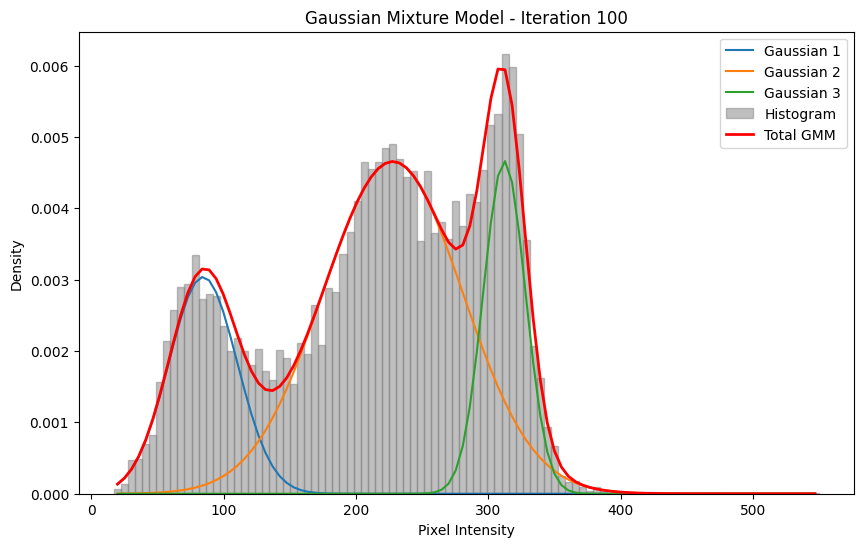

In [7]:

def compute_log_likelihood(data, means, variances, weights):
    responsibilities = computing_weights(data, means, variances, weights)
    log_likelihood = np.sum(np.log(np.sum(responsibilities* weights,axis=1 )))
    return log_likelihood, responsibilities

# EM Algorithm parameters and initialization
iterations = 110
log_likelihoods = []
param_history = {'means': [], 'variances': [], 'weights': []}

# Initialization of parameters (means, variances, weights)
means = [mu1, mu2, mu3]
variances = [sigma1_2, sigma2_2, sigma3_2]
weights = [pi1, pi2, pi3]

# EM Iterations
for iteration in range(iterations):
    # E-step: Compute responsibilities w_n,k
    log_likelihood, responsibilities = compute_log_likelihood(data_no_background, means, variances, weights)
    log_likelihoods.append(log_likelihood)
    
    # M-step: Update parameters based on responsibilities
    N = len(data_no_background)
    for k in range(3):
        # Update the means
        means[k] = np.sum(responsibilities[:, k] * data_no_background) / np.sum(responsibilities[:, k])
        # Update the variances
        variances[k] = np.sum(responsibilities[:, k] * (data_no_background - means[k])**2) / np.sum(responsibilities[:, k])
        # Update the weights
        weights[k] = np.sum(responsibilities[:, k]) / N

    # Store the parameters after each iteration
    param_history['means'].append(means.copy())
    param_history['variances'].append(variances.copy())
    param_history['weights'].append(weights.copy())
    
    # Display the log-likelihood evolution and the GMM plot every 10 iterations
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Log-Likelihood: {log_likelihood}")
        
        # Plot the GMM overlay on the histogram
        plt.figure(figsize=(10, 6))
        hist, bin_edges = np.histogram(data_no_background, bins=100, density=True)
        x = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin centers
        total_gmm = np.zeros_like(x)
        
        # Plot each Gaussian component
        for k in range(3):
            gaussian = weights[k] * compute_gaussian(x, means[k], variances[k])
            total_gmm += gaussian
            plt.plot(x, gaussian, label=f"Gaussian {k+1}")
        
        plt.hist(data_no_background, bins=100, density=True,alpha=0.5, color='gray', edgecolor='gray', label="Histogram")
        plt.plot(x, total_gmm, color='red', linewidth=2, label="Total GMM")
        plt.title(f"Gaussian Mixture Model - Iteration {iteration}")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Density")
        plt.legend()
        plt.show()



In this code, we are implementing the Expectation-Maximization (EM) algorithm to estimate the maximum likelihood parameters for a Gaussian Mixture Model (GMM) that fits the distribution of pixel intensities in an image. The goal is to iteratively update the model’s parameters: means, variances, and weights of the Gaussian components so that the GMM closely approximates the underlying histogram of pixel intensities. Each iteration consists of two steps: the E-step, where we calculate the responsibility weights (probabilities that each pixel belongs to each Gaussian component) based on the current parameters, and the M-step, where we update the parameters using these weights according to maximum likelihood estimation formula. This iterative process aims to maximize the log likelihood, which quantifies how well the GMM fits the data.
As the iterations progress (by adding 10 iterations at a time), the GMM plot becomes increasingly similar to the histogram of pixel intensities, indicating a better fit as we can clearly see in iteration 100. 

110


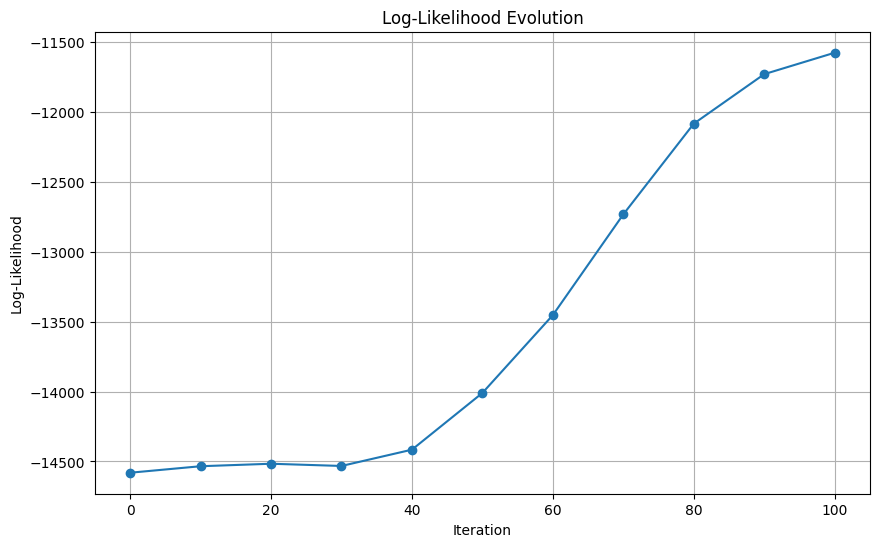

In [8]:

# Plot the final log-likelihood
plt.figure(figsize=(10, 6))
iterations = iterations = np.arange(0, 110, 10)
log_likelihood_subset = np.array(log_likelihoods)[iterations]
print(len(log_likelihoods))
plt.plot(iterations, log_likelihood_subset, marker='o')
plt.title("Log-Likelihood Evolution")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()



This convergence is also reflected in the evolution of the log likelihood, which becomes progressively less negative with more iterations, meaning the likelihood of the observed data given the model parameters is increasing. This trend signifies that the GMM is improving its representation of the data distribution. By the final iterations, the total GMM model effectively approximates the histogram, indicating that the algorithm has reached a point where the model parameters best describe the data distribution.

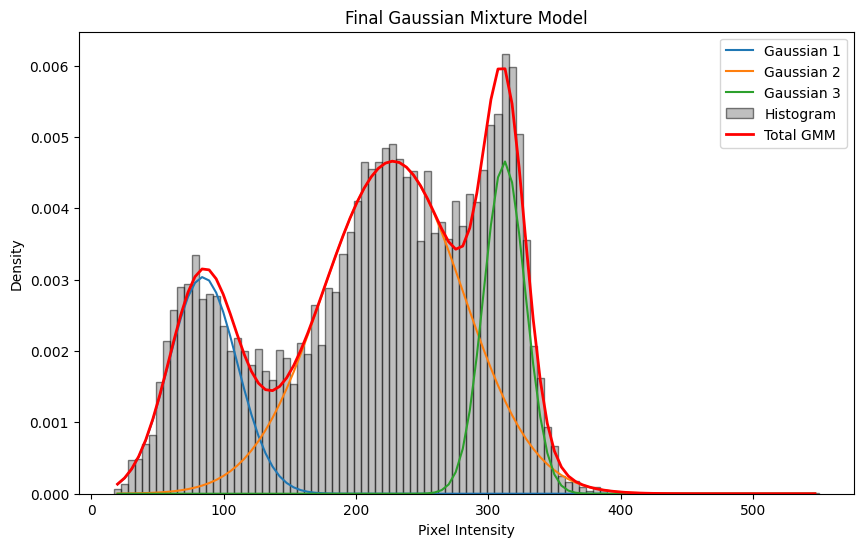

In [9]:

# Final GMM after convergence
plt.figure(figsize=(10, 6))
hist, bin_edges = np.histogram(data_no_background, bins=100, density=True)
x = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin centers
total_gmm = np.zeros_like(x)

for k in range(3):
    gaussian = weights[k] * norm.pdf(x, means[k], np.sqrt(variances[k]))
    total_gmm += gaussian
    plt.plot(x, gaussian, label=f"Gaussian {k+1}")

plt.hist(data_no_background, bins=100, density=True, alpha=0.5, color='gray', edgecolor='black', label="Histogram")
plt.plot(x, total_gmm, color='red', linewidth=2, label="Total GMM")
plt.title("Final Gaussian Mixture Model")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.legend()
plt.show()

This code generates a plot showing the final Gaussian Mixture Model (GMM) after the EM algorithm has converged. The purpose of this plot is to visualize how well the GMM fits the distribution of pixel intensities in the data. For each component, norm.pdf calculates the Gaussian PDF at each x point, and this PDF is scaled by the component's weight. The weighted Gaussian PDF for each component is then added to total_gmm, which accumulates the contributions from all components to create the final GMM distribution. Each individual Gaussian component is plotted as a separate line on the graph to show its shape and position within the overall GMM just like before. Ideally, the "Total GMM" curve should align with the histogram, indicating a good fit which in our case we could say it does.

## Task 6: Vary only one model parameter
Keeping all other parameters fixed to their estimated values, vary only $\mu_2$ (the mean of the middle
Gaussian distribution) between the estimated values of $\mu_1$ and $\mu_3$ in about 100 steps, and plot for
each step the log likelihood function.

In [12]:
variances_i=[sigma1_2, sigma2_2, sigma3_2]
weights_i=[pi1, pi2, pi3]

# Compute responsibilities with mu2 = mu1 for lower bound
fixed_means = np.array([means[0], means[0], means[2]])
fixed_responsibilities = computing_weights(data_no_background, fixed_means, variances_i, weights_i)

# Define the range for mu2
mu2_range = np.linspace(means[0], means[2], 100)

In [13]:
def compute_log_likelihood(data, means, variances, weights):
    N = data.shape[0]
    K = means.shape[0]
    
    log_likelihood = 0.0
    for n in range(N):
        tmp = 0.0
        for k in range(K):
            tmp += weights[k] * norm.pdf(data[n], loc=means[k], scale=np.sqrt(variances[k]))
        log_likelihood += np.log(tmp + 1e-12)  # Numerical stability
    
    return log_likelihood

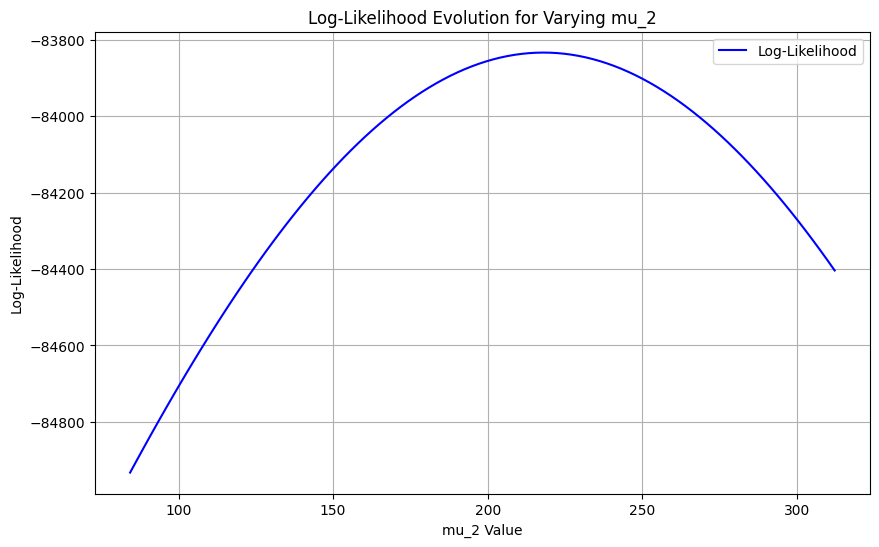

In [16]:
log_likelihoods_mu2 = []
for mu2 in mu2_range: 
    temp_means = np.array([means[0], mu2, means[2]])
    
    # Compute log-likelihood
    log_likelihood = compute_log_likelihood(data_no_background, temp_means, variances_i, weights_i)
    log_likelihoods_mu2.append(log_likelihood)
    
plt.figure(figsize=(10, 6))
plt.plot(mu2_range, log_likelihoods_mu2, label="Log-Likelihood", color="blue")
plt.title("Log-Likelihood Evolution for Varying mu_2")
plt.xlabel("mu_2 Value")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid(True)
plt.show()


We defined a range of values for 𝜇2 between the first and third elements of the means array, with a step size of 0.01. In a loop, we iteratively updated 
𝜇2 in the means array and computed the log-likelihood for each corresponding value by calling the compute_log_likelihood function and the resulting log-likelihood values were stored in the log_likelihoods list. Finally, we plotted the log-likelihoods against the values of 𝜇2. The log-likelihood's peak suggests an optimal region for μ2 where the GMM fits the data most effectively. Moving it too close to 𝜇1 or 𝜇3 reduces the  fit, as indicated by lower log-likelihood values. 

## Task 7: Locate Lower bound
On the same figure, also plot the lower bound corresponding to the parameter vector in which all
parameters are set to their estimated values, except $\mu_2$ which is set to the estimated value of $\mu_1$.

In [18]:
def compute_lower_bound(data, means, variances, weights, responsibilities):
    N, K = responsibilities.shape
    
    Q = 0.0
    
    # Weighted log priors and Gaussian probabilities
    for k in range(K):
        Q += np.sum(responsibilities[:, k] * (np.log(weights[k] + 1e-12) + 
                                             -0.5 * np.log(2 * np.pi * variances[k]) - 
                                             0.5 * ((data - means[k]) ** 2) / variances[k]))
    
    # Entropy
    Q -= np.sum(responsibilities * np.log(responsibilities + 1e-12))
    
    return Q

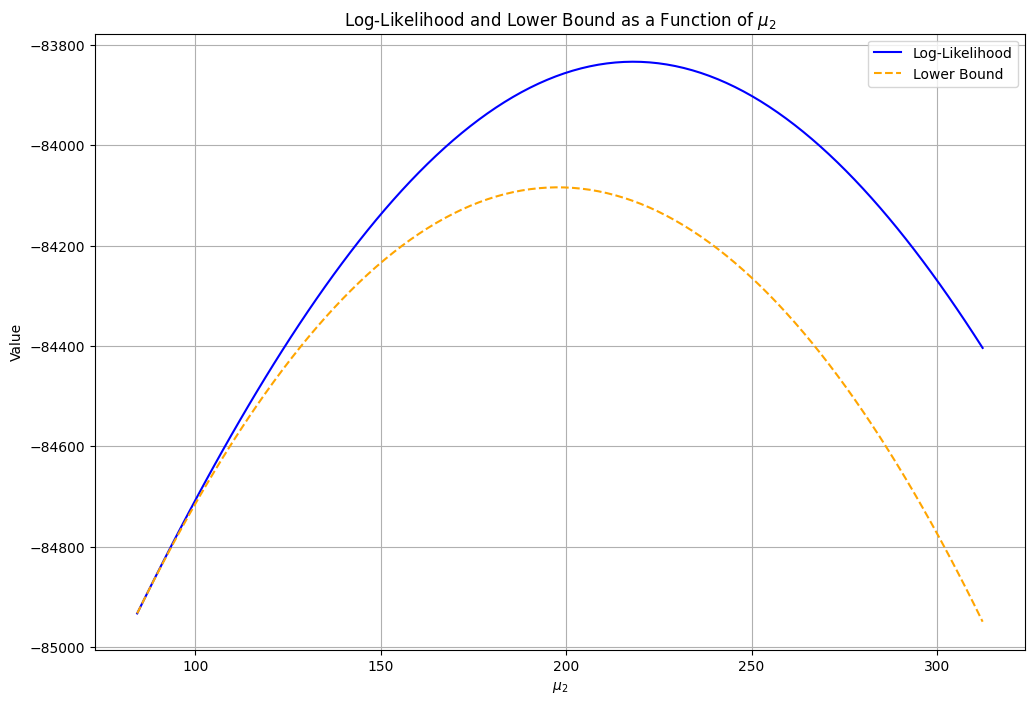

In [ ]:
# Initialize lists to store log-likelihoods and lower bounds
lower_bounds_mu2 = []

for mu2 in mu2_range:
    temp_means = np.array([means[0], mu2, means[2]])
    
    # Compute lower bound
    lower_bound_value = compute_lower_bound(data_no_background, temp_means, variances_i, weights_i, fixed_responsibilities)
    lower_bounds_mu2.append(lower_bound_value)

# Convert lists to numpy arrays for easier handling
log_likelihoods_mu2 = np.array(log_likelihoods_mu2)
lower_bounds_mu2 = np.array(lower_bounds_mu2)

# Plotting Tasks 6-7
plt.figure(figsize=(12, 8))
plt.plot(mu2_range, log_likelihoods_mu2, label="Log-Likelihood", color='blue')
plt.plot(mu2_range, lower_bounds_mu2, label="Lower Bound", color='orange', linestyle='--')

# Labels and Title
plt.title("Log-Likelihood and Lower Bound as a Function of $\\mu_2$")
plt.xlabel("$\\mu_2$")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## Task 8: Maximize lower bound
Compute the value for $\mu_2$ that maximizes this lower bound (first line of eq. 3.35), indicate its location
on the figure, and comment on the result.

Formulate the lower bound as 

$$ Q(\theta \vert \tilde{\theta}) = -\frac{1}{2} \sum^K_{k=1} [\frac{1}{\sigma^2_k} \sum^N_{n=1} w_{n,k} (d_n - \mu_k - \sum^M_{m-1} c_m \phi_{n,m})^2 + (\sum^N_{n-1} w_{n,k}) \log \sigma^2_k] $$

$$ + \sum^K_{k=1} [(\sum^N_{n=1} w_{n,k}) \log \pi_k] $$

$$ - \sum^N_{n=1} \sum^K_{k=1} w_{n,k} \log w_{n,k} - \frac{N}{2} \log (2\pi) $$


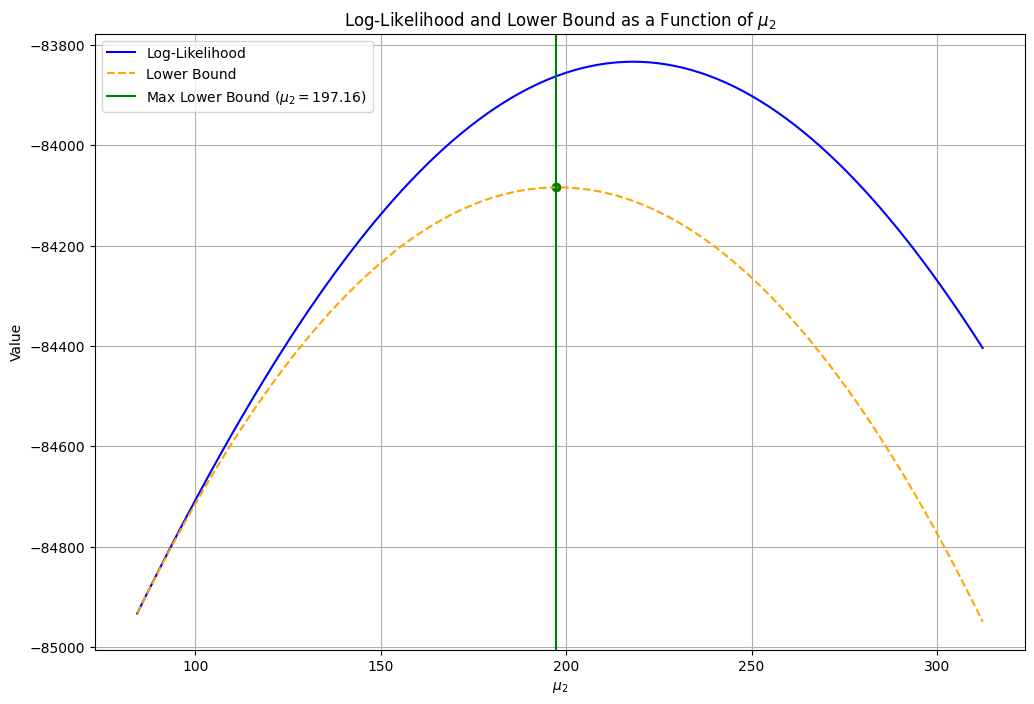

The value of mu2 that maximizes the lower bound is: 197.1571
The maximum lower bound value is: -84083.9771


In [20]:
# Locate the mu2 that maximizes the lower bound
max_lb_index = np.argmax(lower_bounds_mu2)
optimal_mu2 = mu2_range[max_lb_index]
max_lower_bound = lower_bounds_mu2[max_lb_index]

# Plotting Tasks 6-8
plt.figure(figsize=(12, 8))
plt.plot(mu2_range, log_likelihoods_mu2, label="Log-Likelihood", color='blue')
plt.plot(mu2_range, lower_bounds_mu2, label="Lower Bound", color='orange', linestyle='--')
plt.axvline(x=optimal_mu2, color='green', linestyle='-', label=f"Max Lower Bound ($\\mu_2={optimal_mu2:.2f}$)")
plt.scatter(optimal_mu2, max_lower_bound, color='green')  # Highlight the point
    
# Labels and Title
plt.title("Log-Likelihood and Lower Bound as a Function of $\\mu_2$")
plt.xlabel("$\\mu_2$")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal mu2
print(f"The value of mu2 that maximizes the lower bound is: {optimal_mu2:.4f}")
print(f"The maximum lower bound value is: {max_lower_bound:.4f}")


## Conclusion